In [14]:
using HDF5
using LinearAlgebra
using QuantumOptics
using Statistics
using Dates

using Plots

include("LiPoSID.jl")

Main.LiPoSID

In [29]:
function get_seeds_and_timespan(file_name)   
    h5open(file_name,"r") do fid   # read file, preserve existing contents
        seeds = read(fid["seeds"])
        Δt = read(fid["dt"])
        tₘₐₓ = read(fid["t_max"])
        return seeds,  Δt, tₘₐₓ
    end
end

function get_noise_levels(file_name)   
    h5open(file_name,"r") do fid   # read file, preserve existing contents
        noise_levels = keys(fid["data_by_noise_level"])
        return noise_levels
    end
end

function get_variable_names(file_name, noise_level, seed)
        h5open(file_name,"r") do fid   # read file, preserve existing contents
        variable_names = keys(fid["data_by_noise_level"][string(noise_level)][string(seed)])
        return variable_names
    end
end

function get_by_name(file_name, var_name, noise_levels, seeds)
        h5open(file_name,"r") do fid # read file, preserve existing contents
        var_by_name = []
        for w in noise_levels
            current_noise_var = [ read(fid["data_by_noise_level"][string(w)][string(seed)][var_name]) for seed in seeds ]
            push!(var_by_name, current_noise_var)
        end
        return(var_by_name)
    end
end

function get_lsid(file_name, noise, seeds)
    A = get_by_name(file_name, "A", [noise], seeds)[1][1]
    C = get_by_name(file_name, "C", [noise], seeds)[1][1]
    x0 = get_by_name(file_name, "x0", [noise], seeds)[1][1]
    return A, C, x0
end

function get_kraus_sid(file_name, noise, seed)
    ρ0 = get_by_name(file_name, "rho0", [noise], seeds)[1][1]
    K1_sid = get_by_name(file_name, "K1_sid", [noise], seeds)[1][1]
    K2_sid = get_by_name(file_name, "K2_sid", [noise], seeds)[1][1]
    return ρ0, K1_sid, K2_sid
end 

function lindblad_evolution(key, time_limit, Δt, noise_level, seed)
    time_span = [0:Δt:time_limit;]
    H_exact = DenseOperator(basis, get_by_name(file_name, "H_"*key, [noise_level], seed)[1][1])
    J_exact = DenseOperator(basis, get_by_name(file_name, "J_"*key, [noise_level], seed)[1][1])
    ρ0 = DenseOperator(basis, get_by_name(file_name, "rho0", [noise_level], seed)[1][1])
    time, ρ_exact_ser  = timeevolution.master(time_span, ρ0, H_exact, [J_exact])
    ρ = [ρₜ.data for ρₜ in ρ_exact_ser]
end

lindblad_evolution (generic function with 2 methods)

In [39]:
file_name = "C:/Users/Zakhar/Documents/GitHub/JPOP_SID/LiPoSID_clust_compare_methods_started_2022-Jul-15_at_15-12.h5"
seeds,  Δt, tₘₐₓ = get_seeds_and_timespan(file_name)
println(tₘₐₓ)
noise_levels = get_noise_levels(file_name)
train_steps = Integer(tₘₐₓ ÷ Δt)+1
println(train_steps)
time_multipliers = [1:1:10;]
time_horizon = maximum(time_multipliers) * tₘₐₓ
println(time_horizon)
steps_horizon = Integer(time_horizon ÷ Δt)+2
println(steps_horizon)
basis = NLevelBasis(2)
# get_variable_names(file_name, noise_levels[1], seeds[1])

2.0
200
20.0
2001


NLevel(N=2)

In [23]:
typeof(get_kraus_sid(file_name, noise_levels[1], seeds[1]))

Tuple{Matrix{ComplexF64}, Matrix{ComplexF64}, Matrix{ComplexF64}}

In [41]:
res_file_name = "SID_forecasting_fidelity_" * string(Dates.format(now(), "yyyy-u-dd_at_HH-MM")) * ".h5" 
println("Results to be stored in file: " * res_file_name)

for n in 1:length(noise_levels)
    
    noise = noise_levels[n]
    
    println("Processing noise level: " * noise)
        
    h5open(res_file_name,"cw") do fid   # read-write, create file if not existing, preserve existing contents
    noise_group = create_group(fid, string(noise))
    end
          
    # Threads.@threads for seed in seeds[1:2]
    for seed in seeds[1:2]
        
        # println("Processing for seed: "*string(seed))
      
        # Lindblad evolution selies "exact" and recovered
        ρ_exact = lindblad_evolution("exact", time_horizon, Δt, noise, seed)
        ρ_pade = lindblad_evolution("sid_pade", time_horizon, Δt, noise, seed)
        ρ_simp = lindblad_evolution("sid_simp", time_horizon, Δt, noise, seed)
        
        # Series recoveres by linear system identification    
        A, C, x0 = get_lsid(file_name, noise, seed)
        bloch_sid = LiPoSID.propagate(A, C, x0, steps_horizon)
        ρ_lsid = LiPoSID.rho_series_from_bloch(bloch_sid) #[1:length(ρ_exact)]
              
        # Series recovered with Kraus hypothesis 
        ρ0, K1_sid, K2_sid = get_kraus_sid(file_name, noise, seed)
        ρ_kraus = LiPoSID.timeevolution_kraus(steps_horizon, ρ0, [K1_sid, K2_sid])
        
        fid_pade = []
        fid_simp = []
        fid_lsid = []
        fid_kraus = []
               
        for m in 1:length(time_multipliers)  # time scales
            
            step_limit = train_steps * time_multipliers[m]
 
            push!(fid_pade, LiPoSID.min_fidelity_between_series(basis, ρ_pade[1:step_limit], ρ_exact[1:step_limit]))
            push!(fid_simp, LiPoSID.min_fidelity_between_series(basis, ρ_simp[1:step_limit], ρ_exact[1:step_limit]))
            push!(fid_lsid, LiPoSID.min_fidelity_between_series(basis, ρ_lsid[1:step_limit], ρ_exact[1:step_limit]))
            push!(fid_kraus, LiPoSID.min_fidelity_between_series(basis, ρ_kraus[1:step_limit], ρ_exact[1:step_limit]))
        end
        
        h5open(res_file_name,"cw") do fid   # read-write, create file if not existing, preserve existing contents
        noise_group = open_group(fid, string(noise))
        seed_group = create_group(noise_group, string(seed))
        seed_group["fidelity_lsid"] = convert.(Float64, fid_lsid)
        seed_group["fidelity_simp"] = convert.(Float64, fid_simp)
        seed_group["fidelity_pade"] = convert.(Float64, fid_pade)
        seed_group["fidelity_kraus"] = convert.(Float64, fid_kraus)
        end       

    end

end

Results to be stored in file: SID_forecasting_fidelity_2022-Aug-07_at_16-12.h5
Processing noise level: 0.0
Processing for seed: 11736744822501361144
Lindblad
2001
Linear SID 
2001
Kraus
2001
Time multipliers...
Saving...
Processing for seed: 17401799854164395076
Lindblad
2001
Linear SID 
2001
Kraus
2001
Time multipliers...
Saving...
Processing noise level: 0.01
Processing for seed: 11736744822501361144
Lindblad
2001
Linear SID 
2001
Kraus
2001
Time multipliers...
Saving...
Processing for seed: 17401799854164395076
Lindblad
2001
Linear SID 
2001
Kraus
2001
Time multipliers...
Saving...
Processing noise level: 0.02
Processing for seed: 11736744822501361144
Lindblad
2001
Linear SID 
2001
Kraus
2001
Time multipliers...
Saving...
Processing for seed: 17401799854164395076
Lindblad
2001
Linear SID 
2001
Kraus
2001
Time multipliers...
Saving...
Processing noise level: 0.03
Processing for seed: 11736744822501361144
Lindblad
2001
Linear SID 
2001
Kraus
2001
Time multipliers...
Saving...
Processi

In [43]:
function read_fidelities_time_series(file_name, noise, seed)
    h5open(file_name,"r") do fid # read file, preserve existing contents
        fidelity_lsid = read(fid[string(noise)][string(seed)]["fidelity_lsid"])
        fidelity_simp = read(fid[string(noise)][string(seed)]["fidelity_simp"])
        fidelity_pade = read(fid[string(noise)][string(seed)]["fidelity_pade"])
        fidelity_kraus = read(fid[string(noise)][string(seed)]["fidelity_kraus"])

        return(fidelity_lsid, fidelity_simp, fidelity_pade, fidelity_kraus)
    end
end
noise = "0.01"
seed = 17401799854164395076
fidelity_lsid, fidelity_simp, fidelity_pade, fidelity_kraus = read_fidelities_time_series(res_file_name, noise, seed)

([0.9999873379811284, 0.999983736610463, 0.9999788061630157, 0.9999732284456976, 0.9999670179191926, 0.9999601742045646, 0.9999527082693469, 0.9999446205242348, 0.9999359200615955, 0.9999266096622799], [0.9999888315093094, 0.9999888315093094, 0.9999888315093094, 0.9999888315093094, 0.9999888315093094, 0.9999888315093094, 0.9999888315093094, 0.9999888315093094, 0.9999888315093094, 0.9999888315093094], [0.9999812320449534, 0.9999812320449534, 0.9999812320449534, 0.9999812320449534, 0.9999812320449534, 0.9999812320449534, 0.9999812320449534, 0.9999812320449534, 0.9999812320449534, 0.9999812320449534], [0.855833333437066, 0.855833333437066, 0.855833333437066, 0.855833333437066, 0.855833333437066, 0.855833333437066, 0.855833333437066, 0.855833333437066, 0.855833333437066, 0.855833333437066])

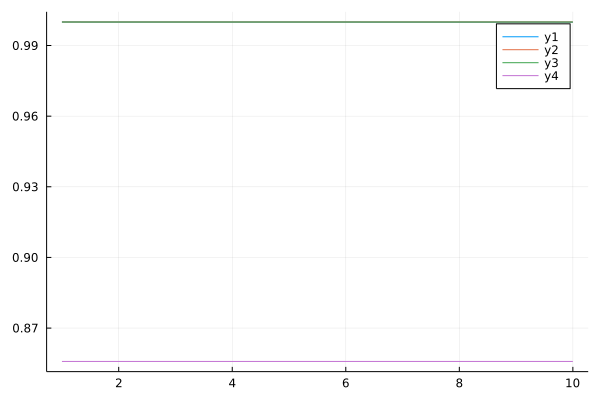

In [52]:
using Plots
plot(fidelity_lsid)
plot!(fidelity_simp)
plot!(fidelity_pade)
plot!(fidelity_kraus)

In [51]:
using DataFrames

df = dataframe(noise, seed, mult, fidelity_lsid, fidelity_simp,)

In [53]:
fidelities = Array{Float64}(undef, length(noise_levels), length(seeds[1:2]), length(time_multipliers), 4)

for n in 1:length(noise_levels)
    for s in 1:length(seeds[1:2])
        noise = noise_levels[n]
        seed = seeds[s]
        fidelity_lsid, fidelity_simp, fidelity_pade, fidelity_kraus = read_fidelities_time_series(res_file_name, noise, seed)
        for m in length(time_multipliers)
            fidelities[n, s, m, 1] = fidelity_lsid[m]
            fidelities[n, s, m, 2] = fidelity_simp[m] 
            fidelities[n, s, m, 3] = fidelity_pade[m] 
            fidelities[n, s, m, 4] = fidelity_kraus[m] 
        end
    end
end 

In [72]:
# Time series with zero noise
fid_lsid_timeseries = mean(fidelities[1,:,:,1], dims=1)
fid_simp_timeseries = mean(fidelities[1,:,:,1], dims=1)
fid_pade_timeseries = mean(fidelities[1,:,:,1], dims=1)
fid_kraus_timeseries = mean(fidelities[1,:,:,1], dims=1)

1×10 Matrix{Float64}:
 5.21207e-314  2.6432e-313  5.30499e-314  …  9.68078e-315  0.741489

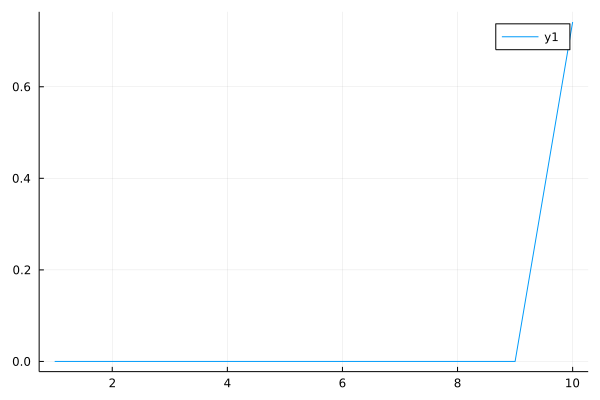

In [76]:
plot(fid_simp_timeseries')

In [70]:
fid_kraus_timeseries

2×1 Matrix{Float64}:
 0.09999999999999726
 0.04829770990034611

In [71]:
fidelities[1,:,:,1]

2×10 Matrix{Float64}:
 1.93616e-314  5.09279e-313  8.48798e-314  …  0.0           1.0
 8.48798e-314  1.93616e-314  2.122e-314       1.93616e-314  0.482977